# Clasificación de Imágenes Satelitales

Este notebook implementa un sistema completo de clasificación de imágenes satelitales con:
- Descarga y preparación de datos
- Dos arquitecturas CNN
- Validación cruzada
- Evaluación completa

In [1]:
# Detectar si estamos en Colab y verificar GPU
try:
    import google.colab
    IN_COLAB = True
    print("✓ Ejecutando en Google Colab")

    # Verificar y configurar GPU
    import subprocess
    gpu_info = subprocess.check_output(['nvidia-smi']).decode('utf-8')
    if 'T4' in gpu_info:
        print("✓ GPU T4 detectada correctamente")
    elif 'GPU' in gpu_info:
        print("⚠ Advertencia: Se detectó GPU pero no es T4")
        print("Para obtener GPU T4: Runtime > Change runtime type > GPU > T4")
    else:
        print("❌ ERROR: No se detectó GPU")
        print("Por favor, activa GPU T4: Runtime > Change runtime type > GPU > T4")
        raise RuntimeError("GPU T4 requerida. Por favor, activa GPU en Colab.")

except ImportError:
    IN_COLAB = False
    print("✓ Ejecutando localmente")
except RuntimeError as e:
    raise e
except Exception as e:
    print(f"⚠ Error verificando GPU: {e}")
    IN_COLAB = True  # Asumimos que estamos en Colab

# Instalación de dependencias
%pip install kagglehub tensorflow scikit-learn matplotlib seaborn numpy pandas pillow -q

print("✓ Dependencias instaladas")


✓ Ejecutando en Google Colab
✓ GPU T4 detectada correctamente
✓ Dependencias instaladas


## a) Descarga y Partición de Datos


In [2]:
import kagglehub
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import glob

# Crear directorio del proyecto para el dataset
project_dir = os.getcwd()
dataset_dir = os.path.join(project_dir, "dataset")
os.makedirs(dataset_dir, exist_ok=True)

# Descargar dataset (kagglehub lo descarga en su ubicación predeterminada)
print("Descargando dataset desde Kaggle...")
download_path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")
print(f"Dataset descargado en: {download_path}")

# Copiar dataset a la carpeta del proyecto
print(f"\nCopiando dataset a: {dataset_dir}")
if os.path.exists(download_path):
    # Si el dataset ya está en dataset_dir, no copiar de nuevo
    if not os.path.exists(os.path.join(dataset_dir, "data")) and not any(
        os.path.isdir(os.path.join(dataset_dir, d))
        for d in ['cloudy', 'desert', 'green_area', 'water']
    ):
        # Copiar todo el contenido del dataset descargado
        for item in os.listdir(download_path):
            src = os.path.join(download_path, item)
            dst = os.path.join(dataset_dir, item)
            if os.path.isdir(src):
                if os.path.exists(dst):
                    shutil.rmtree(dst)
                shutil.copytree(src, dst)
            else:
                shutil.copy2(src, dst)
        print("✓ Dataset copiado a la carpeta del proyecto")
    else:
        print("✓ Dataset ya existe en la carpeta del proyecto")
else:
    print("⚠ Advertencia: No se encontró el dataset descargado")

# Usar el dataset de la carpeta del proyecto
dataset_path = dataset_dir
print(f"\nDataset disponible en: {dataset_path}")


Descargando dataset desde Kaggle...
Using Colab cache for faster access to the 'satellite-image-classification' dataset.
Dataset descargado en: /kaggle/input/satellite-image-classification

Copiando dataset a: /content/dataset
✓ Dataset copiado a la carpeta del proyecto

Dataset disponible en: /content/dataset


In [3]:
# Explorar estructura del dataset
print("Contenido del directorio del dataset:")
for item in os.listdir(dataset_path):
    item_path = os.path.join(dataset_path, item)
    if os.path.isdir(item_path):
        num_files = len(glob.glob(os.path.join(item_path, "*.jpg")) +
                        glob.glob(os.path.join(item_path, "*.png")) +
                        glob.glob(os.path.join(item_path, "*.JPG")) +
                        glob.glob(os.path.join(item_path, "*.PNG")))
        print(f"  {item}: {num_files} imágenes")

# Buscar las clases en subdirectorios si es necesario
classes_found = []
for root, dirs, files in os.walk(dataset_path):
    for dir_name in dirs:
        if dir_name in ['cloudy', 'desert', 'green_area', 'water']:
            class_path = os.path.join(root, dir_name)
            num_files = len(glob.glob(os.path.join(class_path, "*.jpg")) +
                            glob.glob(os.path.join(class_path, "*.png")) +
                            glob.glob(os.path.join(class_path, "*.JPG")) +
                            glob.glob(os.path.join(class_path, "*.PNG")))
            if num_files > 0 and dir_name not in classes_found:
                classes_found.append(dir_name)
                print(f"  Clase encontrada: {dir_name} ({num_files} imágenes) en {class_path}")


Contenido del directorio del dataset:
  data: 0 imágenes
  Clase encontrada: cloudy (1500 imágenes) en /content/dataset/data/cloudy
  Clase encontrada: desert (1131 imágenes) en /content/dataset/data/desert
  Clase encontrada: green_area (1500 imágenes) en /content/dataset/data/green_area
  Clase encontrada: water (1500 imágenes) en /content/dataset/data/water


In [4]:
# Función para crear partición train/test (80/20)
def create_train_test_split(source_path, train_path, test_path, test_size=0.2, random_state=42):
    """
    Crea partición 80/20 de train/test manteniendo estructura de carpetas
    """
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    # Clases del dataset
    classes = ['cloudy', 'desert', 'green_area', 'water']

    for class_name in classes:
        # Crear carpetas para train y test
        train_class_path = os.path.join(train_path, class_name)
        test_class_path = os.path.join(test_path, class_name)
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        # Buscar todas las imágenes de esta clase (buscar en todo el árbol de directorios)
        images = []

        # Primero intentar en la raíz
        class_source_path = os.path.join(source_path, class_name)
        if os.path.exists(class_source_path):
            images = glob.glob(os.path.join(class_source_path, "*.jpg")) + \
                     glob.glob(os.path.join(class_source_path, "*.png")) + \
                     glob.glob(os.path.join(class_source_path, "*.JPG")) + \
                     glob.glob(os.path.join(class_source_path, "*.PNG"))

        # Si no se encontraron, buscar en subdirectorios
        if len(images) == 0:
            for root, dirs, files in os.walk(source_path):
                if class_name.lower() in root.lower() or any(class_name.lower() in d.lower() for d in dirs):
                    search_path = root if class_name.lower() in root.lower() else os.path.join(root, class_name)
                    if os.path.exists(search_path):
                        found = glob.glob(os.path.join(search_path, "*.jpg")) + \
                                glob.glob(os.path.join(search_path, "*.png")) + \
                                glob.glob(os.path.join(search_path, "*.JPG")) + \
                                glob.glob(os.path.join(search_path, "*.PNG"))
                        if found:
                            images = found
                            break

        if len(images) > 0:
            # Dividir imágenes
            train_images, test_images = train_test_split(
                images, test_size=test_size, random_state=random_state
            )

            # Copiar a train
            for img_path in train_images:
                shutil.copy2(img_path, train_class_path)

            # Copiar a test
            for img_path in test_images:
                shutil.copy2(img_path, test_class_path)

            print(f"{class_name}: {len(train_images)} train, {len(test_images)} test")
        else:
            print(f"⚠ Advertencia: No se encontraron imágenes para {class_name}")

# Crear particiones usando rutas relativas
base_dir = os.getcwd()
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

create_train_test_split(dataset_path, train_dir, test_dir)
print(f"\nPartición completada:")
print(f"Train: {train_dir}")
print(f"Test: {test_dir}")


cloudy: 1200 train, 300 test
desert: 904 train, 227 test
green_area: 1200 train, 300 test
water: 1200 train, 300 test

Partición completada:
Train: /content/train
Test: /content/test


## b) Validación Cruzada con 2 Arquitecturas CNN


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import pandas as pd

# Configuración
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS_CV = 10
NUM_FOLDS = 3

# Clases
CLASSES = ['cloudy', 'desert', 'green_area', 'water']
NUM_CLASSES = len(CLASSES)

print(f"TensorFlow version: {tf.__version__}")

# Verificar GPU y configurar
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ GPU detectada: {len(gpus)} dispositivo(s)")
    for gpu in gpus:
        print(f"  - {gpu}")
    # Configurar crecimiento de memoria para evitar errores
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✓ Configuración de GPU completada")
    except RuntimeError as e:
        print(f"⚠ Error configurando GPU: {e}")

    # Verificar que TensorFlow puede usar la GPU
    if tf.test.is_gpu_available():
        print("✓ TensorFlow puede usar GPU")
    else:
        print("⚠ Advertencia: TensorFlow no puede usar GPU")
else:
    if IN_COLAB:
        print("❌ ERROR: No se detectó GPU en TensorFlow")
        print("Por favor, activa GPU T4: Runtime > Change runtime type > GPU > T4")
        raise RuntimeError("GPU T4 requerida para el entrenamiento")
    else:
        print("⚠ Advertencia: No se detectó GPU, se usará CPU (más lento)")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TensorFlow version: 2.19.0
✓ GPU detectada: 1 dispositivo(s)
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
✓ Configuración de GPU completada
✓ TensorFlow puede usar GPU


In [6]:
# Función para crear generadores de datos
def create_data_generator(data_dir, batch_size=32, shuffle=True, validation_split=0.0):
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=validation_split
    )

    generator = datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=shuffle,
        subset='training' if validation_split > 0 else None
    )

    return generator

# Función para crear generador de validación
def create_val_generator(data_dir, batch_size=32, validation_split=0.0):
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=validation_split
    )

    generator = datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        subset='validation'
    )

    return generator


In [7]:
# Arquitectura CNN 1: Red Simple con Capas Convolucionales Básicas
def create_cnn1():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Arquitectura CNN 2: Red con Bloques Convolucionales y Batch Normalization
def create_cnn2():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Mostrar arquitecturas
print("=== CNN 1 ===")
model1 = create_cnn1()
model1.summary()

print("\n=== CNN 2 ===")
model2 = create_cnn2()
model2.summary()


=== CNN 1 ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,088,452 (49.93 MB)

 Trainable params: 13,088,452 (49.93 MB)

 Non-trainable params: 0 (0.00 B)


=== CNN 2 ===


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 252, 252, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 124, 124, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 122, 122, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 59, 59, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 57, 57, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 26, 26, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    22,151,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 22,870,180 (87.24 MB)

 Trainable params: 22,868,196 (87.24 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [8]:
# Función para realizar validación cruzada
def cross_validate_cnn(model_creator, model_name, train_dir, n_splits=3, epochs=10):
    """
    Realiza validación cruzada k-fold
    """
    # Obtener todas las rutas de imágenes y sus etiquetas
    image_paths = []
    labels = []

    for class_idx, class_name in enumerate(CLASSES):
        class_dir = os.path.join(train_dir, class_name)
        if os.path.exists(class_dir):
            images = glob.glob(os.path.join(class_dir, "*.jpg")) + \
                     glob.glob(os.path.join(class_dir, "*.png")) + \
                     glob.glob(os.path.join(class_dir, "*.JPG")) + \
                     glob.glob(os.path.join(class_dir, "*.PNG"))
            image_paths.extend(images)
            labels.extend([class_idx] * len(images))

    image_paths = np.array(image_paths)
    labels = np.array(labels)

    # K-Fold Cross Validation
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    print(f"\n=== Validación Cruzada {n_splits}-Fold para {model_name} ===")

    for fold, (train_idx, val_idx) in enumerate(kfold.split(image_paths)):
        print(f"\nFold {fold + 1}/{n_splits}")

        # Crear directorios temporales para este fold
        temp_train_dir = f"temp_train_fold_{fold}"
        temp_val_dir = f"temp_val_fold_{fold}"

        os.makedirs(temp_train_dir, exist_ok=True)
        os.makedirs(temp_val_dir, exist_ok=True)

        # Copiar imágenes a directorios temporales
        for class_name in CLASSES:
            os.makedirs(os.path.join(temp_train_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(temp_val_dir, class_name), exist_ok=True)

        # Separar imágenes
        train_paths = image_paths[train_idx]
        train_labels = labels[train_idx]
        val_paths = image_paths[val_idx]
        val_labels = labels[val_idx]

        # Copiar archivos
        for img_path, label in zip(train_paths, train_labels):
            class_name = CLASSES[label]
            shutil.copy2(img_path, os.path.join(temp_train_dir, class_name))

        for img_path, label in zip(val_paths, val_labels):
            class_name = CLASSES[label]
            shutil.copy2(img_path, os.path.join(temp_val_dir, class_name))

        # Crear generadores
        train_gen = create_data_generator(temp_train_dir, BATCH_SIZE, shuffle=True)
        val_gen = create_data_generator(temp_val_dir, BATCH_SIZE, shuffle=False)

        # Crear y entrenar modelo
        model = model_creator()

        steps_per_epoch = len(train_paths) // BATCH_SIZE
        validation_steps = len(val_paths) // BATCH_SIZE

        history = model.fit(
            train_gen,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            validation_data=val_gen,
            validation_steps=validation_steps,
            verbose=1
        )

        # Evaluar
        val_loss, val_acc = model.evaluate(val_gen, steps=validation_steps, verbose=0)
        accuracies.append(val_acc)
        print(f"Fold {fold + 1} - Accuracy: {val_acc:.4f}")

        # Limpiar
        shutil.rmtree(temp_train_dir)
        shutil.rmtree(temp_val_dir)
        del model
        tf.keras.backend.clear_session()

    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)

    print(f"\n{model_name} - Accuracy promedio: {mean_acc:.4f} +/- {std_acc:.4f}")

    return mean_acc, std_acc, accuracies

# Realizar validación cruzada para ambas arquitecturas
results = {}

print("=" * 60)
mean1, std1, accs1 = cross_validate_cnn(create_cnn1, "CNN1", train_dir, n_splits=NUM_FOLDS, epochs=EPOCHS_CV)
results['CNN1'] = {'mean': mean1, 'std': std1, 'accuracies': accs1}

print("\n" + "=" * 60)
mean2, std2, accs2 = cross_validate_cnn(create_cnn2, "CNN2", train_dir, n_splits=NUM_FOLDS, epochs=EPOCHS_CV)
results['CNN2'] = {'mean': mean2, 'std': std2, 'accuracies': accs2}



=== Validación Cruzada 3-Fold para CNN1 ===

Fold 1/3
Found 3002 images belonging to 4 classes.
Found 1502 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 31s 192ms/step - accuracy: 0.5428 - loss: 0.8338 - val_accuracy: 0.7609 - val_loss: 0.4829
Epoch 2/10
 1/93 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.6562 - loss: 0.6567

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6562 - loss: 0.6567 - val_accuracy: 0.8281 - val_loss: 0.4743
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.8199 - loss: 0.4151 - val_accuracy: 0.8519 - val_loss: 0.3518
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9062 - loss: 0.2576 - val_accuracy: 0.8390 - val_loss: 0.3585
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.8532 - loss: 0.3532 - val_accuracy: 0.8675 - val_loss: 0.3227
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8750 - loss: 0.2458 - val_accuracy: 0.8736 - val_loss: 0.3138
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.8711 - loss: 0.3171 - val_accuracy: 0.8845 - val_loss: 0.2830
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9062 - loss: 0.1801 - val_accuracy: 0.8641 - val_loss: 0.3089
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.8406 - loss: 0.3643 - val_accuracy: 0.8682 - val_loss: 0

In [9]:
# Crear tabla de resultados
results_table = pd.DataFrame({
    'CNN': ['CNN1', 'CNN2'],
    'Desempeño': [
        f"{results['CNN1']['mean']:.4f} +/- {results['CNN1']['std']:.4f}",
        f"{results['CNN2']['mean']:.4f} +/- {results['CNN2']['std']:.4f}"
    ]
})

print("\n" + "=" * 60)
print("TABLA DE RESULTADOS - VALIDACIÓN CRUZADA (3-Fold)")
print("=" * 60)
print(results_table.to_string(index=False))
print("=" * 60)

# Determinar mejor modelo
if mean1 > mean2:
    best_model_name = "CNN1"
    best_model_creator = create_cnn1
    print(f"\nMejor modelo: CNN1 (Accuracy: {mean1:.4f} +/- {std1:.4f})")
else:
    best_model_name = "CNN2"
    best_model_creator = create_cnn2
    print(f"\nMejor modelo: CNN2 (Accuracy: {mean2:.4f} +/- {std2:.4f})")



TABLA DE RESULTADOS - VALIDACIÓN CRUZADA (3-Fold)
 CNN         Desempeño
CNN1 0.8451 +/- 0.0229
CNN2 0.6465 +/- 0.0587

Mejor modelo: CNN1 (Accuracy: 0.8451 +/- 0.0229)


## c) Entrenamiento Final y Evaluación en Test


In [10]:
# Entrenar el mejor modelo con todo el conjunto de entrenamiento
print(f"\nEntrenando {best_model_name} con todo el conjunto de entrenamiento...")

# Crear generadores
train_gen = create_data_generator(train_dir, BATCH_SIZE, shuffle=True)
test_gen = create_data_generator(test_dir, BATCH_SIZE, shuffle=False)

# Crear modelo
final_model = best_model_creator()

# Calcular steps
train_steps = len(glob.glob(os.path.join(train_dir, "**", "*.jpg"), recursive=True) +
                  glob.glob(os.path.join(train_dir, "**", "*.png"), recursive=True)) // BATCH_SIZE
test_steps = len(glob.glob(os.path.join(test_dir, "**", "*.jpg"), recursive=True) +
                 glob.glob(os.path.join(test_dir, "**", "*.png"), recursive=True)) // BATCH_SIZE

# Entrenar
EPOCHS_FINAL = 20
history = final_model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    epochs=EPOCHS_FINAL,
    verbose=1
)

# Guardar modelo usando ruta relativa
model_path = 'best_model.h5'
final_model.save(model_path)
print(f"\nModelo guardado como '{model_path}'")



Entrenando CNN1 con todo el conjunto de entrenamiento...
Found 4504 images belonging to 4 classes.
Found 1127 images belonging to 4 classes.
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


140/140 ━━━━━━━━━━━━━━━━━━━━ 22s 121ms/step - accuracy: 0.5946 - loss: 0.8016
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 76us/step - accuracy: 0.7188 - loss: 0.6081
Epoch 3/20
  1/140 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step - accuracy: 0.8750 - loss: 0.3553

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.8077 - loss: 0.4330
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 110us/step - accuracy: 0.8750 - loss: 0.4861
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.8396 - loss: 0.3678
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 76us/step - accuracy: 0.8750 - loss: 0.2770
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.8502 - loss: 0.3574
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 83us/step - accuracy: 0.8438 - loss: 0.4260
Epoch 9/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.8729 - loss: 0.3113
Epoch 10/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 117us/step - accuracy: 0.9688 - loss: 0.1614
Epoch 11/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.8468 - loss: 0.3263
Epoch 12/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 78us/step - accuracy: 0.9375 - loss: 0.2370
Epoch 13/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.8812 - loss: 0.2774
Epoch 14/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0


Modelo guardado como 'best_model.h5'


In [11]:
# Evaluar en conjunto de prueba
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener predicciones
print("\nEvaluando en conjunto de prueba...")
test_gen = create_data_generator(test_dir, BATCH_SIZE, shuffle=False)

# Resetear generador
test_gen.reset()
y_true = []
y_pred = []

# Obtener todas las predicciones
for i in range(test_steps):
    batch_x, batch_y = next(test_gen)
    predictions = final_model.predict(batch_x, verbose=0)
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

# Calcular métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
cm = confusion_matrix(y_true, y_pred)

print("\n" + "=" * 60)
print("RESULTADOS EN CONJUNTO DE PRUEBA")
print("=" * 60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("=" * 60)

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=CLASSES))



Evaluando en conjunto de prueba...
Found 1127 images belonging to 4 classes.

RESULTADOS EN CONJUNTO DE PRUEBA
Accuracy:  0.8750
Precision: 0.8809
Recall:    0.8750
F1-Score:  0.8744

Reporte de Clasificación:
              precision    recall  f1-score   support

      cloudy       0.93      0.91      0.92       300
      desert       0.90      0.96      0.93       227
  green_area       0.91      0.75      0.82       300
       water       0.78      0.90      0.83       293

    accuracy                           0.88      1120
   macro avg       0.88      0.88      0.88      1120
weighted avg       0.88      0.88      0.87      1120



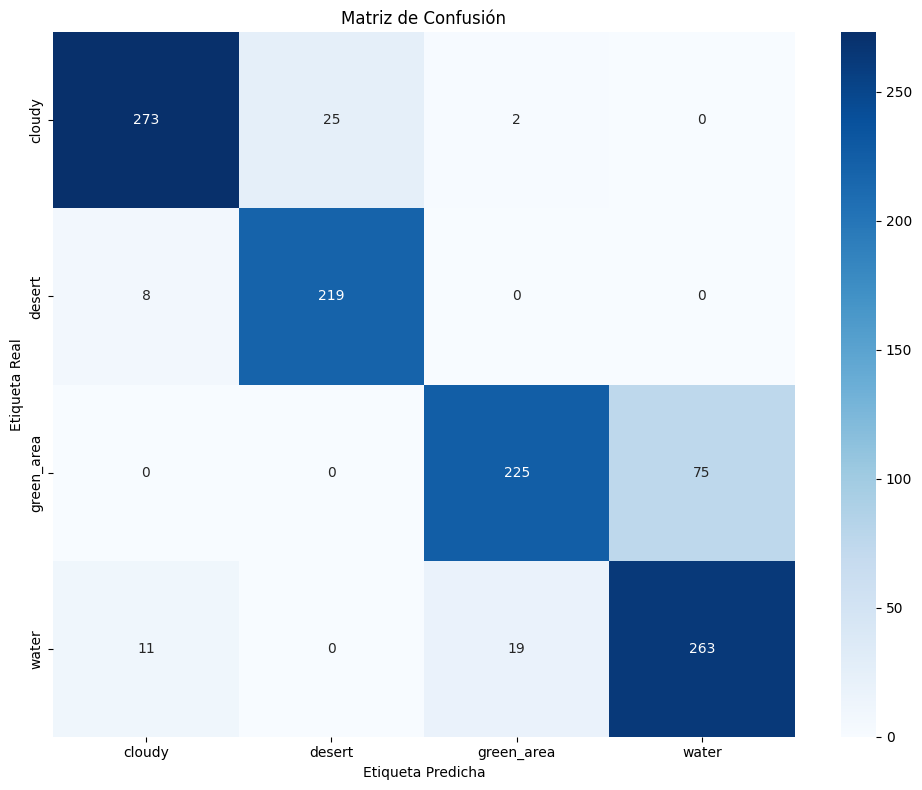


Matriz de confusión guardada como 'confusion_matrix.png'


<Figure size 640x480 with 0 Axes>

In [12]:
# Visualizar matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.show()

# Guardar matriz usando ruta relativa
confusion_path = 'confusion_matrix.png'
plt.savefig(confusion_path, dpi=300, bbox_inches='tight')
print(f"\nMatriz de confusión guardada como '{confusion_path}'")


## d) Ejemplos de Predicciones Correctas e Incorrectas


In [14]:
from PIL import Image
import random

# Función para cargar y preprocesar imagen
def load_and_preprocess_image(img_path):
    img = Image.open(img_path)
    # Convertir a RGB si es necesario (maneja RGBA, L, etc.)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img, dtype=np.float32) / 255.0
    # Asegurar que tenga 3 canales
    if len(img_array.shape) == 2:  # Si es escala de grises
        img_array = np.stack([img_array] * 3, axis=-1)
    elif img_array.shape[2] == 4:  # Si es RGBA
        img_array = img_array[:, :, :3]  # Tomar solo RGB
    # Asegurar que sea float32 y tenga la forma correcta
    img_array = img_array.astype(np.float32)
    return img_array

# Obtener todas las imágenes del test con sus etiquetas reales
test_images_data = []
for class_idx, class_name in enumerate(CLASSES):
    class_dir = os.path.join(test_dir, class_name)
    if os.path.exists(class_dir):
        images = glob.glob(os.path.join(class_dir, "*.jpg")) + \
                 glob.glob(os.path.join(class_dir, "*.png")) + \
                 glob.glob(os.path.join(class_dir, "*.JPG")) + \
                 glob.glob(os.path.join(class_dir, "*.PNG"))
        for img_path in images:
            test_images_data.append({
                'path': img_path,
                'true_label': class_idx,
                'true_class': class_name
            })

# Hacer predicciones para todas las imágenes
print("Generando predicciones para todas las imágenes de test...")
for item in test_images_data:
    img_array = load_and_preprocess_image(item['path'])
    img_batch = np.expand_dims(img_array, axis=0)
    prediction = final_model.predict(img_batch, verbose=0)
    item['pred_label'] = np.argmax(prediction[0])
    item['pred_class'] = CLASSES[item['pred_label']]
    item['confidence'] = np.max(prediction[0])
    item['correct'] = item['true_label'] == item['pred_label']

# Separar correctas e incorrectas
correct_predictions = [item for item in test_images_data if item['correct']]
incorrect_predictions = [item for item in test_images_data if not item['correct']]

print(f"\nTotal de imágenes: {len(test_images_data)}")
print(f"Correctas: {len(correct_predictions)}")
print(f"Incorrectas: {len(incorrect_predictions)}")


Generando predicciones para todas las imágenes de test...

Total de imágenes: 1127
Correctas: 985
Incorrectas: 142


In [15]:
# Seleccionar 5 ejemplos correctos de diferentes clases
correct_examples = []
used_classes = set()
for item in correct_predictions:
    if item['true_class'] not in used_classes and len(correct_examples) < 5:
        correct_examples.append(item)
        used_classes.add(item['true_class'])

# Si no tenemos 5 clases diferentes, completar con más ejemplos
if len(correct_examples) < 5:
    for item in correct_predictions:
        if len(correct_examples) < 5:
            correct_examples.append(item)

# Seleccionar 5 ejemplos incorrectos de diferentes clases
incorrect_examples = []
used_classes = set()
for item in incorrect_predictions:
    if item['true_class'] not in used_classes and len(incorrect_examples) < 5:
        incorrect_examples.append(item)
        used_classes.add(item['true_class'])

# Si no tenemos 5 clases diferentes, completar con más ejemplos
if len(incorrect_examples) < 5:
    for item in incorrect_predictions:
        if len(incorrect_examples) < 5:
            incorrect_examples.append(item)

print(f"Ejemplos correctos seleccionados: {len(correct_examples)}")
print(f"Ejemplos incorrectos seleccionados: {len(incorrect_examples)}")


Ejemplos correctos seleccionados: 5
Ejemplos incorrectos seleccionados: 5


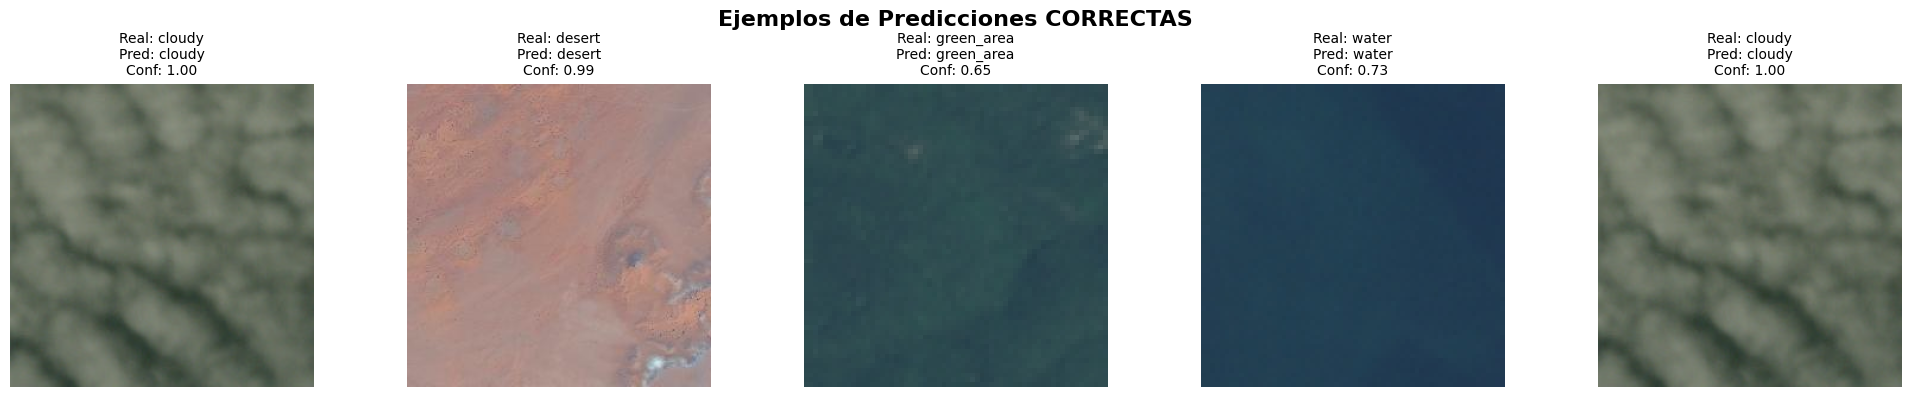

Imagen guardada: correct_predictions.png


In [16]:
# Visualizar ejemplos correctos
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Ejemplos de Predicciones CORRECTAS', fontsize=16, fontweight='bold')

for idx, example in enumerate(correct_examples[:5]):
    img = Image.open(example['path'])
    axes[idx].imshow(img)
    axes[idx].set_title(
        f"Real: {example['true_class']}\nPred: {example['pred_class']}\nConf: {example['confidence']:.2f}",
        fontsize=10
    )
    axes[idx].axis('off')

plt.tight_layout()
correct_path = 'correct_predictions.png'
plt.savefig(correct_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Imagen guardada: {correct_path}")


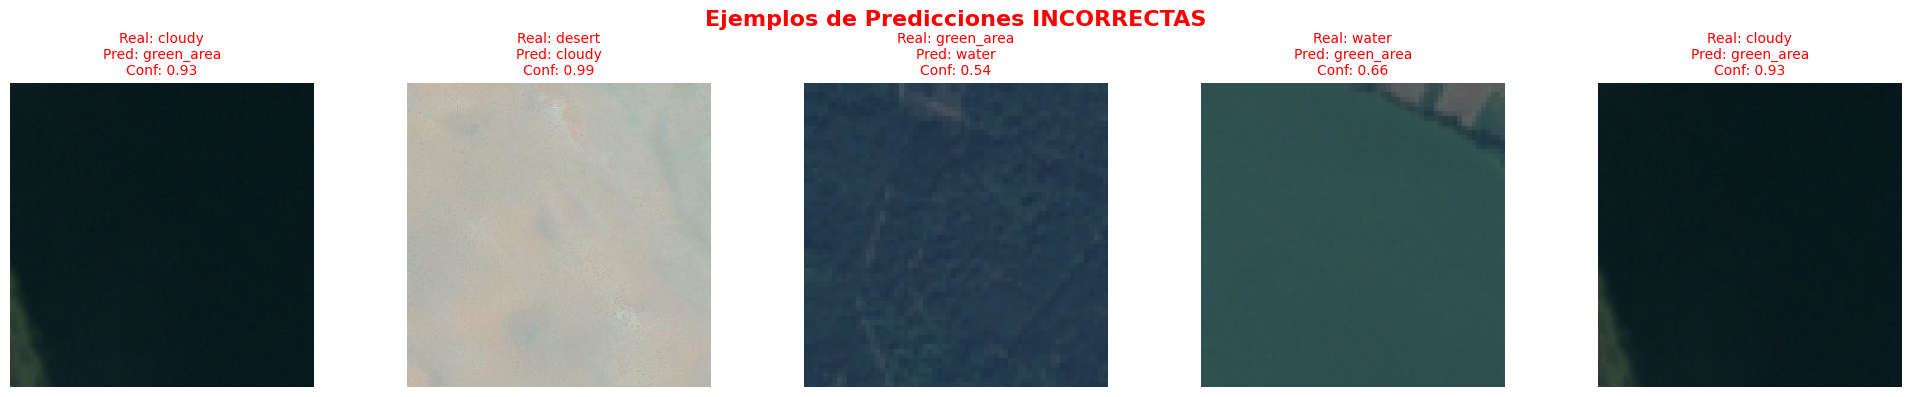

Imagen guardada: incorrect_predictions.png


In [17]:
# Visualizar ejemplos incorrectos
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Ejemplos de Predicciones INCORRECTAS', fontsize=16, fontweight='bold', color='red')

for idx, example in enumerate(incorrect_examples[:5]):
    img = Image.open(example['path'])
    axes[idx].imshow(img)
    axes[idx].set_title(
        f"Real: {example['true_class']}\nPred: {example['pred_class']}\nConf: {example['confidence']:.2f}",
        fontsize=10,
        color='red'
    )
    axes[idx].axis('off')

plt.tight_layout()
incorrect_path = 'incorrect_predictions.png'
plt.savefig(incorrect_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Imagen guardada: {incorrect_path}")


### Análisis y Discusión

**Casos donde el modelo funciona bien:**
1. **Imágenes con características distintivas claras**: El modelo funciona mejor cuando las características visuales de cada clase son claramente diferentes (por ejemplo, agua azul vs. desierto arenoso).
2. **Imágenes con buena resolución y contraste**: Las imágenes nítidas con buen contraste entre elementos facilitan la clasificación.
3. **Clases con patrones únicos**: Áreas verdes con vegetación densa, nubes blancas sobre fondo azul, etc.

**Casos donde el modelo falla:**
1. **Imágenes ambiguas o de transición**: Imágenes que muestran características de múltiples clases (ej: área verde cerca del agua, nubes parciales).
2. **Condiciones de iluminación extremas**: Imágenes muy oscuras o muy brillantes pueden confundir al modelo.
3. **Escalas diferentes**: El modelo puede tener dificultades cuando los objetos aparecen en escalas muy diferentes a las vistas durante el entrenamiento.
4. **Oclusiones o imágenes parciales**: Cuando solo se ve una porción de la clase (ej: solo una esquina de un área verde).
5. **Similitud visual entre clases**: Por ejemplo, desierto arenoso claro puede confundirse con nubes, o agua turbia con áreas verdes oscuras.

**Posibles mejoras:**
- Aumento de datos (data augmentation) más agresivo
- Uso de transfer learning con modelos pre-entrenados (ResNet, VGG, etc.)
- Ajuste fino de hiperparámetros
- Ensamblaje de modelos
- Análisis de atención para entender qué regiones de la imagen influyen más en la decisión
